# Определение перспективного тарифа для телеком компании

## Описание проекта
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Нужно понять, какой тариф приносит больше денег, чтобы скорректировать рекламный бюджет.

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. У нас есть данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Оглавление
- [Шаг 1. Изучим общую информацию о файле.](#step1)
- [Шаг 2. Подготовка данных.](#step2)
- [Шаг 3. Анализ данных.](#step3)
- [Шаг 4. Проверка гипотез.](#step4)
- [Шаг 5. Общий вывод.](#step5)

## Описание данных

Таблица *users* (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

Таблица *calls* (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

Таблица *messages* (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

Таблица *internet* (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

Таблица *tariffs* (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

#### Примечание. 
Если объединение таблиц методом merge приводит к ошибке dead kernell, примените метод join — это облегчит нагрузку на Jupiter Notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import math

### Шаг 1. Изучим общую информацию о файле. <a id=step1></a>

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
message = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
for name in (calls, internet, message, users):
    display(name.head(10))
    display(name.info())
    display(name.describe())
    print('------------------------------------------------------------')

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


------------------------------------------------------------


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


------------------------------------------------------------


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


------------------------------------------------------------


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


------------------------------------------------------------


### Шаг 2. Подготовка данных. <a id=step2></a>

Приведем столбцы с датами во всех таблицах к типу datetime.

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
message['message_date'] =  pd.to_datetime(message['message_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [5]:
for df in [calls, internet, message, users, tariffs]:
    display(df.head(5))
    print('------------------------------------------------------------')

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


------------------------------------------------------------


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


------------------------------------------------------------


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


------------------------------------------------------------


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


------------------------------------------------------------


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


------------------------------------------------------------


In [6]:
# Отдельным столбцом вынесем месяц в каждом из датасетов.

calls['month'] = pd.DatetimeIndex(calls['call_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
message['month'] = pd.DatetimeIndex(message['message_date']).month
users['month'] = pd.DatetimeIndex(users['reg_date']).month

for name in [calls, internet, message, users]:
    display(name.head())

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5


In [7]:
# Мы знаем, что тарифный план округляет время звонка до целых минуит и до мегабайт в большую сторону. 
# Это мы и сделаем, чтобы посчитать количество полных истраченных минут и мегабайт.

calls['duration'] = np.ceil(calls['duration']).astype('int')
internet['mb_used'] = np.ceil(internet['mb_used']).astype('int')
display(calls.head())
display(internet.head())

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,113,2018-11-25,1000,11
1,1,1000_1,1053,2018-09-07,1000,9
2,2,1000_2,1198,2018-06-25,1000,6
3,3,1000_3,551,2018-08-22,1000,8
4,4,1000_4,303,2018-09-24,1000,9


Text(0.5, 0, 'calls_number')

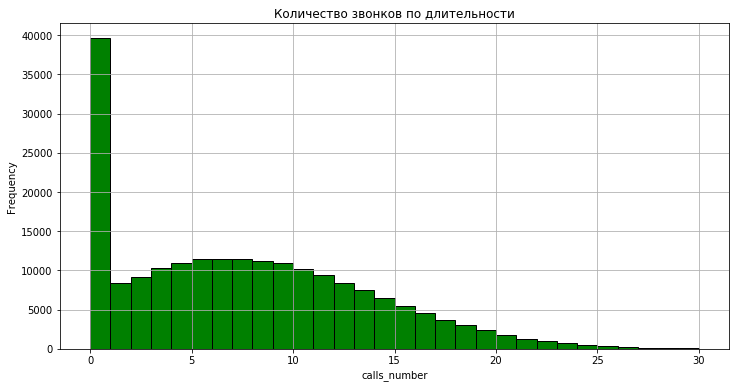

In [8]:
calls['duration'].plot(kind='hist', 
                       ec='black', 
                       bins=30, 
                       grid=True, 
                       range=(0, 30), 
                       figsize=(12, 6),
                      color='green',
                      title='Количество звонков по длительности'
                    )
plt.xlabel('calls_number')

Text(0, 0.5, 'calls number')

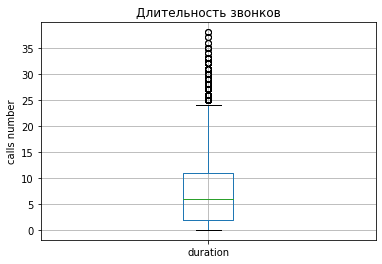

In [9]:
calls.boxplot('duration')
plt.title('Длительность звонков')
plt.ylabel('calls number')

Text(0, 0.5, 'calls number')

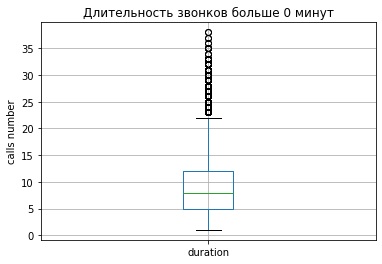

In [10]:
calls.query('duration > 0').boxplot('duration')
plt.title('Длительность звонков больше 0 минут')
plt.ylabel('calls number')

Видим колоссальное количество звонков длительностью 0 минут (пропущенные звонки). Самая частая длитльность звонков после 0 минут - 7  минут.
Если мы уберем звонки длительностью 0 минут, то медиана с 6 минут увеличится до 8 минут примерно, но станет гораздо больше выбросов.

#### Сделаем сводные таблицы, которые будут показывать:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [11]:
# Количество сделанных звонков и израсходованных минут разговора:
calls_pivot = calls.pivot_table(index =['month', 'user_id'], 
                               values='duration', 
                               aggfunc=['count', 'sum']).reset_index()

calls_pivot.columns = ['month', 'user_id', 'calls_count', 'min_sum']
calls_pivot

,month,user_id,calls_count,min_sum
0,1,1005,15,95
1,1,1032,61,380
2,1,1045,1,9
3,1,1055,64,551
4,1,1071,24,194
...,...,...,...,...
3169,12,1494,62,418
3170,12,1495,155,1031
3171,12,1496,80,518
3172,12,1497,71,545


In [12]:
# Количество отправленных сообщений по месяцам:
message_pivot = message.pivot_table(index=['month', 'user_id'],
                                    values='id', 
                                    aggfunc='count').reset_index()

message_pivot.columns = ['month', 'user_id', 'message_count']
message_pivot

,month,user_id,message_count
0,1,1005,7
1,1,1032,38
2,1,1045,5
3,1,1055,30
4,1,1071,16
...,...,...,...
2712,12,1493,78
2713,12,1495,84
2714,12,1496,51
2715,12,1497,17


Text(0, 0.5, 'frequency')

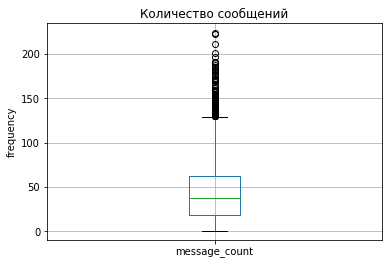

In [13]:
message_pivot.boxplot('message_count')
plt.title('Количество сообщений')
plt.ylabel('frequency')

In [14]:
# Объем израсходованного интернет-трафика по месяцам:
internet_pivot = internet.pivot_table(index=['month', 'user_id'], 
                                     values='mb_used',
                                     aggfunc='sum').reset_index()
internet_pivot.columns = ['month', 'user_id', 'mb_used']
internet_pivot

,month,user_id,mb_used
0,1,1005,2730
1,1,1032,24147
2,1,1045,2348
3,1,1055,17111
4,1,1071,15622
...,...,...,...
3198,12,1494,17645
3199,12,1495,23450
3200,12,1496,20757
3201,12,1497,19940


In [15]:
# Соединим воедино таблички со звонками, сообщениями и интернет данными.

#calls_messages = calls_pivot.merge(message_pivot, on=['user_id', 'month'], how='left')
#calls_messages_int = calls_messages.merge(internet_pivot, on=['user_id', 'month'], how='left')
#len(calls_messages_int)

In [16]:
calls_messages = calls_pivot.merge(message_pivot, on=['user_id', 'month'], how='outer')
calls_messages_int = calls_messages.merge(internet_pivot, on=['user_id', 'month'], how='outer')
len(calls_messages_int)

3214

In [17]:
#Уберем из таблички users столбец с месяцем, так как он будет дублироваться в новой табличке.

users_new = users[['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name','reg_date', 'tariff']]
cmi_users = calls_messages_int.merge(users_new, on='user_id', how='left')
display(cmi_users.head(10))
display(cmi_users.describe())
display(cmi_users.info())

,month,user_id,calls_count,min_sum,message_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1,1005,15.0,95.0,7.0,2730.0,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
1,1,1032,61.0,380.0,38.0,24147.0,31,NaN,Ульяновск,Инна,Игнатьева,2018-01-04,smart
2,1,1045,1.0,9.0,5.0,2348.0,48,NaN,Улан-Удэ,Джемма,Карасева,2018-01-30,smart
3,1,1055,64.0,551.0,30.0,17111.0,39,NaN,Казань,Луиза,Березина,2018-01-02,smart
4,1,1071,24.0,194.0,16.0,15622.0,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart
5,1,1113,18.0,110.0,14.0,767.0,52,NaN,Чита,Харитон,Булгаков,2018-01-24,smart
6,1,1120,5.0,55.0,NaN,657.0,25,NaN,Краснодар,Агнесса,Абдулина,2018-01-24,ultra
7,1,1126,35.0,272.0,4.0,16377.0,71,NaN,Санкт-Петербург,Яна,Арсенкова,2018-01-19,ultra
8,1,1134,42.0,332.0,32.0,10215.0,65,NaN,Красноярск,Марьяна,Авросимова,2018-01-16,smart
9,1,1135,9.0,90.0,1.0,1601.0,64,NaN,Архангельск,Милена,Воронина,2018-01-29,smart


,month,user_id,calls_count,min_sum,message_count,mb_used,age
count,3214.000000,3214.000000,3174.000000,3174.000000,2717.000000,3203.000000,3214.000000
mean,8.317362,1251.590230,63.833333,456.931632,45.283769,17286.749610,46.641568
std,2.905413,144.659172,32.678036,238.031270,35.051363,7523.580332,16.586109
min,1.000000,1000.000000,1.000000,0.000000,1.000000,0.000000,18.000000
25%,6.000000,1125.000000,41.000000,290.000000,19.000000,12543.000000,32.000000
50%,9.000000,1253.000000,63.000000,447.000000,38.000000,16985.000000,46.000000
75%,11.000000,1378.750000,83.000000,592.000000,63.000000,21455.500000,62.000000
max,12.000000,1499.000000,244.000000,1673.000000,224.000000,49789.000000,75.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 13 columns):
month            3214 non-null int64
user_id          3214 non-null int64
calls_count      3174 non-null float64
min_sum          3174 non-null float64
message_count    2717 non-null float64
mb_used          3203 non-null float64
age              3214 non-null int64
churn_date       187 non-null object
city             3214 non-null object
first_name       3214 non-null object
last_name        3214 non-null object
reg_date         3214 non-null datetime64[ns]
tariff           3214 non-null object
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memory usage: 351.5+ KB


None

In [18]:
# Чтобы соединить две таблицы cmi_users и tariffs, нужно переименовать столбец, по которому будем соединять.

tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']
tariffs.columns

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff'],
      dtype='object')

In [19]:
whole_df = cmi_users.merge(tariffs, on='tariff', how='outer')
whole_df.head(5)

,month,user_id,calls_count,min_sum,message_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1,1005,15.0,95.0,7.0,2730.0,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3
1,1,1032,61.0,380.0,38.0,24147.0,31,NaN,Ульяновск,Инна,Игнатьева,2018-01-04,smart,50,15360,500,550,200,3,3
2,1,1045,1.0,9.0,5.0,2348.0,48,NaN,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,50,15360,500,550,200,3,3
3,1,1055,64.0,551.0,30.0,17111.0,39,NaN,Казань,Луиза,Березина,2018-01-02,smart,50,15360,500,550,200,3,3
4,1,1071,24.0,194.0,16.0,15622.0,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,50,15360,500,550,200,3,3


Мы имеем пропуски в столбцах с количеством сообщений, количеством звонком и истраченных минут разговора, объемом израсходованного трафика и с датой окончания использования тарифа.
Мы знаем. что если дата окончания не стоит, то эти пользователи остались на этом тарифе. По поводу остальных логично предположить, что пропуски означают, что эти люди не пользовались упомянутыми выше опциями тарифа.

In [20]:
# заменим пропуски в количестве сообщений и в использованном трафике на 0, 
# так как предполагаем, что эти люди просто не пользовались интернетом и сообщениями
# и изменим тип данныз в сообщениях на int

for column in ('message_count', 'mb_used', 'calls_count', 'min_sum'):
    whole_df[column] = whole_df[column].fillna(0)
    
whole_df['message_count'] = whole_df['message_count'].astype('int')
whole_df['mb_used'] = np.ceil(whole_df['mb_used'])
whole_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
month                    3214 non-null int64
user_id                  3214 non-null int64
calls_count              3214 non-null float64
min_sum                  3214 non-null float64
message_count            3214 non-null int64
mb_used                  3214 non-null float64
age                      3214 non-null int64
churn_date               187 non-null object
city                     3214 non-null object
first_name               3214 non-null object
last_name                3214 non-null object
reg_date                 3214 non-null datetime64[ns]
tariff                   3214 non-null object
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute     

In [21]:
# Также изменим тип данных в столбце churn_date на datetime.

whole_df['churn_date'] = pd.to_datetime(whole_df['churn_date'], format='%Y-%m-%d')
whole_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
month                    3214 non-null int64
user_id                  3214 non-null int64
calls_count              3214 non-null float64
min_sum                  3214 non-null float64
message_count            3214 non-null int64
mb_used                  3214 non-null float64
age                      3214 non-null int64
churn_date               187 non-null datetime64[ns]
city                     3214 non-null object
first_name               3214 non-null object
last_name                3214 non-null object
reg_date                 3214 non-null datetime64[ns]
tariff                   3214 non-null object
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_min

Находим помесячную выручку с каждого пользователя.

In [22]:
def month_calc(row):
    calls = row['min_sum']
    messages = row['message_count']
    internet = row['mb_used']
    tariff = row['tariff']
    
    # достанем лимиты по тарифам на звонки, смс и интернет
    minutes_lim = tariffs.loc[tariffs['tariff'] == tariff, 'minutes_included'].array[0]
    mess_lim = tariffs.loc[tariffs['tariff'] == tariff, 'messages_included'].array[0]
    inter_lim = tariffs.loc[tariffs['tariff'] == tariff, 'mb_per_month_included'].array[0]
    
    # переплата по звонкам
    call_overlimit = max(calls - minutes_lim, 0)
    call_overpay = call_overlimit * tariffs.loc[tariffs['tariff'] == tariff, 'rub_per_minute'].array[0]
    
    # переплата по сообщениям
    message_overlimit = max(messages - mess_lim, 0)
    message_overpay = message_overlimit * tariffs.loc[
        tariffs['tariff'] == tariff, 'rub_per_message'].array[0]
    
    # переплата за трафик интернета
    internet_overlimit = max(internet - inter_lim, 0)
    internet_overpay = (internet_overlimit /1024) * tariffs.loc[
        tariffs['tariff'] == tariff, 'rub_per_gb'].array[0]
    
    return (np.ceil(call_overpay + message_overpay 
            + internet_overpay 
            + tariffs.loc[tariffs['tariff'] == tariff, 'rub_monthly_fee'].array[0]))

whole_df['profit'] = whole_df.apply(month_calc, axis=1)

whole_df.head(10)

,month,user_id,calls_count,min_sum,message_count,mb_used,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1,1005,15.0,95.0,7,2730.0,67,NaT,Набережные Челны,Афанасий,...,2018-01-25,smart,50,15360,500,550,200,3,3,550.0
1,1,1032,61.0,380.0,38,24147.0,31,NaT,Ульяновск,Инна,...,2018-01-04,smart,50,15360,500,550,200,3,3,2267.0
2,1,1045,1.0,9.0,5,2348.0,48,NaT,Улан-Удэ,Джемма,...,2018-01-30,smart,50,15360,500,550,200,3,3,550.0
3,1,1055,64.0,551.0,30,17111.0,39,NaT,Казань,Луиза,...,2018-01-02,smart,50,15360,500,550,200,3,3,1045.0
4,1,1071,24.0,194.0,16,15622.0,20,2018-08-31,Омск,Гектор,...,2018-01-09,smart,50,15360,500,550,200,3,3,602.0
5,1,1113,18.0,110.0,14,767.0,52,NaT,Чита,Харитон,...,2018-01-24,smart,50,15360,500,550,200,3,3,550.0
6,1,1134,42.0,332.0,32,10215.0,65,NaT,Красноярск,Марьяна,...,2018-01-16,smart,50,15360,500,550,200,3,3,550.0
7,1,1135,9.0,90.0,1,1601.0,64,NaT,Архангельск,Милена,...,2018-01-29,smart,50,15360,500,550,200,3,3,550.0
8,1,1155,44.0,337.0,48,20151.0,71,NaT,Ставрополь,Александр,...,2018-01-02,smart,50,15360,500,550,200,3,3,1486.0
9,1,1176,25.0,187.0,20,6864.0,37,NaT,Волгоград,Радим,...,2018-01-20,smart,50,15360,500,550,200,3,3,550.0


### Шаг 3. Анализ данных. <a id=step3></a>

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [23]:
whole_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 21 columns):
month                    3214 non-null int64
user_id                  3214 non-null int64
calls_count              3214 non-null float64
min_sum                  3214 non-null float64
message_count            3214 non-null int64
mb_used                  3214 non-null float64
age                      3214 non-null int64
churn_date               187 non-null datetime64[ns]
city                     3214 non-null object
first_name               3214 non-null object
last_name                3214 non-null object
reg_date                 3214 non-null datetime64[ns]
tariff                   3214 non-null object
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_min

Text(0, 0.5, 'frequency')

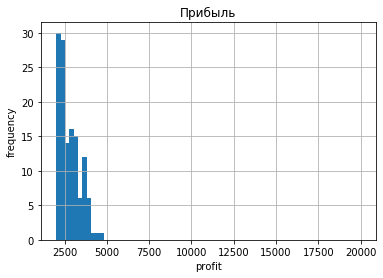

In [24]:
ultra = whole_df.query('tariff == "ultra"')
smart = whole_df.query('tariff == "smart"')

ultra['profit'].hist(bins=70, range=(2000, 20000))
plt.title('Прибыль')
plt.xlabel('profit')
plt.ylabel('frequency')

#display(ultra.head())
#display(smart.head())

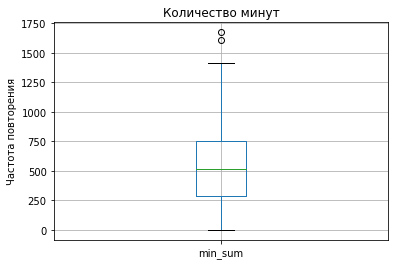

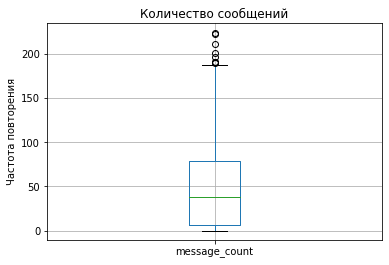

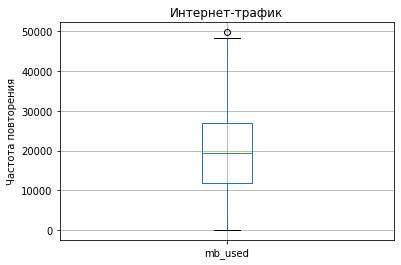

In [25]:
dict_for_titles = {'min_sum':'Количество минут', 'message_count':'Количество сообщений', 'mb_used':'Интернет-трафик'}
for column in ['min_sum', 'message_count', 'mb_used']:
    ultra.boxplot(column)
    plt.ylabel('Частота повторения')
    plt.title(dict_for_titles[column])
    plt.show()

In [26]:
ultra.describe()

,month,user_id,calls_count,min_sum,message_count,mb_used,age,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.000000
mean,8.250761,1263.094416,73.392893,526.623350,49.363452,19486.901523,46.834518,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,2060.598985
std,2.871762,140.694908,43.916853,317.606098,47.804457,10096.317202,17.107979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,356.455650
min,1.000000,1000.000000,0.000000,0.000000,0.000000,0.000000,18.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.000000
25%,6.000000,1143.000000,41.000000,284.000000,6.000000,11785.000000,30.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.000000
50%,9.000000,1277.000000,74.000000,518.000000,38.000000,19324.000000,45.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.000000
75%,11.000000,1381.000000,104.000000,752.000000,79.000000,26863.000000,63.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.000000
max,12.000000,1495.000000,244.000000,1673.000000,224.000000,49789.000000,75.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,4744.000000


In [27]:
ultra['mb_used'].quantile([0.7, 0.8, 0.86, 0.9])

0.70    25033.60
0.80    28269.20
0.86    30582.68
0.90    33008.20
Name: mb_used, dtype: float64

#### Ультра
##### Минуты разговора и сообщения
Для пользователей тарифа "Ультра" 3000 минут и 1000 сообщений явно очень много, ибо максимум, который был истрачен в минутах = 1673, а максимум по количество отправленных сообщений = 224. Сообщения явно выходят из моды.
##### Интернет
С  инетрнетом все иначе. 86% пользователям достаточно того пакета, который предоставляет оператов в данном тарифе. Возможно, стоит глобально уменьшить количество сообщений и минут в пользу интернета либо дать возможность внутри тарифа менять пакет одних даннх на пакет других данных.

In [28]:
ultra.shape

(985, 21)

In [29]:
ultra = ultra.query('min_sum < 1500 and message_count<180 and mb_used < 33000')
ultra.shape

(874, 21)

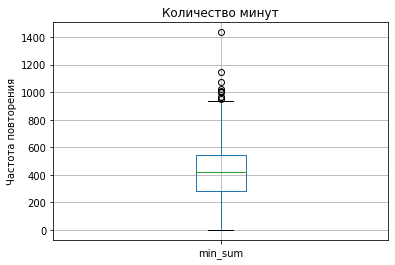

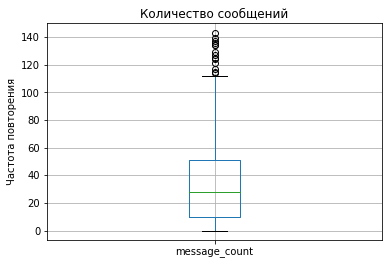

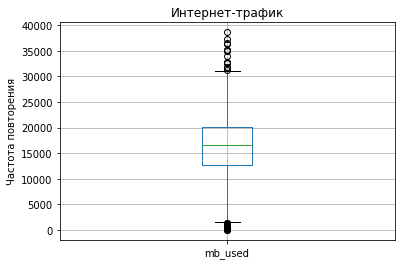

In [30]:
dict_for_titles = {'min_sum':'Количество минут', 'message_count':'Количество сообщений', 'mb_used':'Интернет-трафик'}
for column in ['min_sum', 'message_count', 'mb_used']:
    smart.boxplot(column)
    plt.ylabel('Частота повторения')
    plt.title(dict_for_titles[column])
    plt.show()

In [31]:
smart.describe()

,month,user_id,calls_count,min_sum,message_count,mb_used,age,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.000000
mean,8.346792,1246.506505,58.463437,417.934948,33.384029,16229.188425,46.556303,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,1233.641095
std,2.920316,146.119496,25.939858,190.313730,28.227876,5877.576978,16.353371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,787.844994
min,1.000000,1001.000000,0.000000,0.000000,0.000000,0.000000,18.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,550.000000
25%,6.000000,1121.000000,40.000000,282.000000,10.000000,12658.000000,32.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,550.000000
50%,9.000000,1239.000000,60.000000,422.000000,28.000000,16531.000000,47.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,960.000000
75%,11.000000,1376.000000,76.000000,545.000000,51.000000,20068.000000,62.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,1669.000000
max,12.000000,1499.000000,198.000000,1435.000000,143.000000,38610.000000,75.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,6712.000000


In [32]:
display(smart['min_sum'].quantile([0.5, 0.66, 0.7, 0.99]))
display('----------------------------')
display(smart['message_count'].quantile([0.7, 0.74,0.99]))
display('----------------------------')
display((smart['mb_used'].quantile([0.25, 0.3, 0.4, 0.99])))

0.50    422.00
0.66    499.00
0.70    520.00
0.99    872.72
Name: min_sum, dtype: float64

'----------------------------'

0.70     46.0
0.74     50.0
0.99    108.0
Name: message_count, dtype: float64

'----------------------------'

0.25    12658.00
0.30    13609.40
0.40    15165.00
0.99    29727.04
Name: mb_used, dtype: float64

#### Смарт
##### Минуты разговора
500 минут на разговоры хватает всего лишь 66% пользователей, остальные же вынуждены доплачивать за дп. минуты. 
##### Сообщения
Пакета на 50 сообщений хватает 74% пользователям.
##### Интернет
С интернетом все совсем хуже. Данный пакет на 15360 мб не превышает только 40%, а оставшейся больше части пользователей (60%) приходится докупать дополнительный трафик.

In [33]:
smart.shape

(2229, 21)

In [34]:
smart = smart.query('min_sum < 873 and min_sum > 0 and message_count<108 and mb_used < 30000')
smart.shape

(2155, 21)

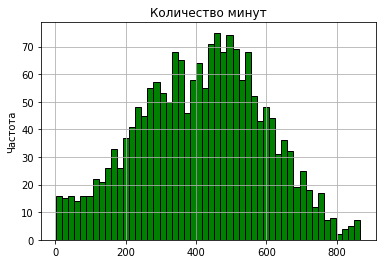

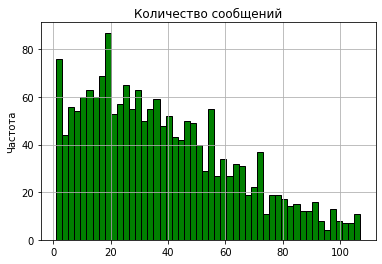

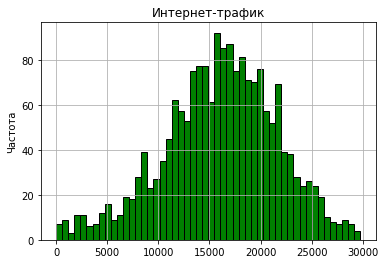

In [35]:
dict_for_titles = {'min_sum':'Количество минут', 'message_count':'Количество сообщений', 'mb_used':'Интернет-трафик'}

for column in ['min_sum', 'message_count', 'mb_used']:
    smart.query('message_count > 0').hist(
        column, 
        bins=50, 
        color='green', 
        ec='black')
    plt.ylabel('Частота')
    plt.title(dict_for_titles[column])
    plt.show()

#### Тариф Смарт
Распределение на графике звонков мы можем отнести к скошенному, а именно с отрицательной скошенностью. Медиана отличается не сильно, но все же в этом столбце она больше среднего, что вполне соотносится с графиком.

Касательно сообщений можем сказать, что на графике видно распределение Пуассона, где скос в положительную сторону, об этом же свидетельствует среднее, которое чуть больше медианы.

В случае с объемом трафика интернета наблюдаем распределение приближенное к нормальному, соответственно медианы со средним различаются совсем слабо.

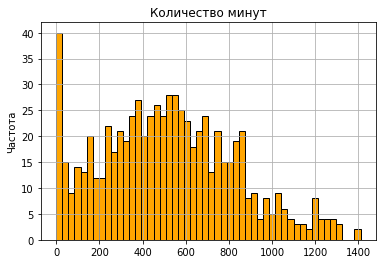

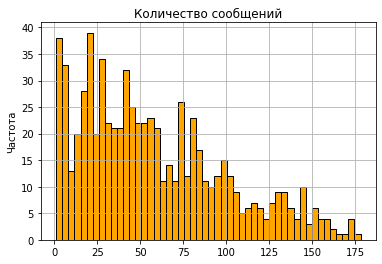

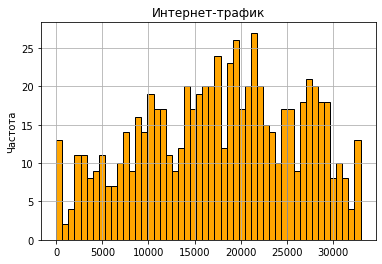

In [36]:
dict_for_titles = {'min_sum':'Количество минут', 'message_count':'Количество сообщений', 'mb_used':'Интернет-трафик'}

for column in ['min_sum', 'message_count', 'mb_used']:
    ultra.query('message_count > 0').hist(
        column, 
        bins=50, 
        color='orange', 
        ec='black')
    plt.ylabel('Частота')
    plt.title(dict_for_titles[column])
    plt.show()

#### Тариф Ультра
Ситуация с количеством минут очень похожа на тариф Смарт, собственно среднее и медиана относятся примерно одинаково друг к другу в обоих тарифах.

Распределение количества сообщений в целом идет по убывающей - самые частые 0-60 сообщений, самое редкое встречающееся явление - 150-180 сообщений.

График объема интернетного трафика немного отличается от тарифа Смарт. График Ультры более рваный, но мы видимо совсем небольшую отрицательную скошенность.

Text(0, 0.5, 'Прибыль')

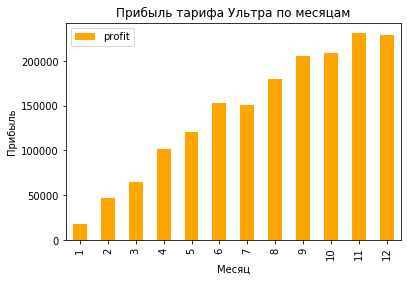

In [37]:
# Посмотрим, как изменялась прибыть от месяца к месяцу в тарифе "Ультра"
(ultra.pivot_table(index='month',
                 values='profit',
                 aggfunc='sum')
 .reset_index()
 .plot(kind='bar', 
       x='month', 
       y='profit',
      color='orange'))
plt.title('Прибыль тарифа Ультра по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Прибыль')

Text(0, 0.5, 'Прибыль')

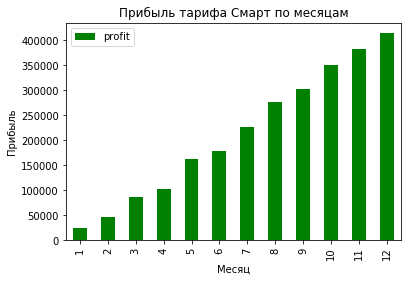

In [38]:
(smart.pivot_table(index='month',
                 values='profit',
                 aggfunc='sum')
 .reset_index()
 .plot(kind='bar', 
       x='month', 
       y='profit',
      color='green'))
plt.title('Прибыль тарифа Смарт по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Прибыль')

Как на одном, так и на другом графике сумма выручки за месяц росла. Такое постепенное увеличение выручки объясняется увеличением количества пользователей каждого тарифа, поэтому объективно называть более удобный тариф по графикам невозможно.

Посчитаем дисперсию, среднее занчение и стандартное отклонение.

In [39]:
round(whole_df.groupby('tariff')['min_sum', 'message_count', 'mb_used']
      .agg(['var', 'mean', 'std'])).reset_index()

tariff   min_sum               message_count                  mb_used  \
               var   mean    std           var  mean   std          var   
0  smart   36219.0  418.0  190.0         797.0  33.0  28.0   34545911.0   
1  ultra  100874.0  527.0  318.0        2285.0  49.0  48.0  101935621.0   

                     
      mean      std  
0  16229.0   5878.0  
1  19487.0  10096.0

Посмотрим как менялось среднее в срезе по конкретным услугам и стандартное отклонение в каждом тарифе по месяцам.

In [40]:
round(smart.groupby('month')['min_sum', 'message_count', 'mb_used', 'profit']
      .agg(['mean','std'])
      .reset_index())

month min_sum        message_count        mb_used          profit       
            mean    std          mean   std     mean     std    mean    std
0      1   210.0  152.0          18.0  16.0   8504.0  6551.0   707.0  426.0
1      2   299.0  191.0          24.0  22.0  11611.0  6255.0   804.0  513.0
2      3   392.0  192.0          31.0  25.0  15296.0  5673.0  1124.0  666.0
3      4   370.0  184.0          31.0  25.0  13417.0  5692.0   917.0  525.0
4      5   387.0  187.0          34.0  27.0  15825.0  5985.0  1147.0  687.0
5      6   392.0  168.0          33.0  27.0  15719.0  5601.0  1117.0  644.0
6      7   406.0  179.0          32.0  26.0  15710.0  5852.0  1152.0  692.0
7      8   418.0  180.0          32.0  27.0  16480.0  5379.0  1217.0  700.0
8      9   429.0  181.0          33.0  27.0  16297.0  5088.0  1185.0  678.0
9     10   417.0  173.0          33.0  27.0  16569.0  5733.0  1248.0  751.0
10    11   430.0  169.0          34.0  27.0  16737.0  5164.0  1240.0  678.0
11    12   456.0  170.0          35.0  29.0  17507.0  4796.0  1335.0  745.0

In [41]:
round(ultra.groupby('month')['min_sum', 'message_count', 'mb_used', 'profit']
      .agg(['mean','std'])
      .reset_index())

month min_sum        message_count        mb_used           profit      
            mean    std          mean   std     mean      std    mean   std
0      1   428.0  270.0          34.0  31.0  13154.0   6872.0  1950.0   0.0
1      2   297.0  297.0          22.0  27.0  11787.0  10654.0  1973.0  78.0
2      3   458.0  259.0          33.0  43.0  16406.0   9924.0  1954.0  16.0
3      4   463.0  274.0          32.0  38.0  15765.0   8847.0  1957.0  40.0
4      5   509.0  286.0          38.0  39.0  17713.0   8382.0  1953.0  24.0
5      6   478.0  301.0          40.0  40.0  17553.0   8012.0  1962.0  59.0
6      7   567.0  300.0          48.0  44.0  17579.0   7596.0  1957.0  45.0
7      8   504.0  316.0          49.0  44.0  16850.0   8407.0  1955.0  34.0
8      9   532.0  328.0          51.0  43.0  17705.0   8448.0  1958.0  44.0
9     10   535.0  310.0          55.0  45.0  17885.0   8096.0  1955.0  35.0
10    11   521.0  294.0          52.0  46.0  17475.0   7829.0  1958.0  42.0
11    12   587.0  321.0          59.0  48.0  18919.0   8113.0  1954.0  31.0

Если посмотреть на std по месяцам в среде по каждой их опций тарифа, то в тарифе Ультра от начала года к концу стандартное отклонение меняется сильнее.

Но если посмотреть на std прибыли от начала к концу года, то std Смарта в десятки раз, а по некоторым месяцам и того больше, превышает std прибыли тарифа Ультра. 

Среднее значение прибыли Смарта в конце года почти в два раза выросло по сравнению с январем, для Ультра оно осталось почти таким же, как и в начале года.

Большим спросом явно пользуется тариф Смарт, прибыль от него увеличивается с каждым месяцем, как и стандартное отклонение. Тариф Ультра топчетя на одном месте и дохода от него больше не становится.

### Шаг 4. Проверка гипотез. <a id=step4></a>

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;


Пороговое значение alpha задайте самостоятельно.


Поясните:
- как вы формулировали нулевую и альтернативную гипотезы;
- какой критерий использовали для проверки гипотез и почему.

-------------------------------------------------------------------------------------------------------------------------------

- Пороговое значение alpha в обоих случаях зададим 0.05.
- Нулевая гипотеза в обоих случаях будет содержать знак равенства, чтобы значения не были экстремальными, а лежали там, где их ожидают. Альтернативная гипотеза будет содержать противоположное утеверждение.
- Критерием для проверки гипотезы будет р-уровень значимости, который показывает вероятность того, что мы получили такие или еще более выраженные различия абсолютно случайно. Чем меньше р-уровень значимости, тем больше оснований отклонить нулевую гипотезу.

##### Проверим первую гипотезу
Нулевая гипотеза (H0): "Средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова".

Альтернативная гипотеза (H1): "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается".

In [42]:
alpha = 0.05

result = st.ttest_ind(smart['profit'], ultra['profit'])
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевая гипотеза остается в силе')

p-значение: 2.613942684946132e-203
Отвергаем нулевую гипотезу


И все-таки гипотеза о том, что "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается" более вероятна. И это было вполне ожидаемо, так как стоимость тарифа "Смарт" в 3,5 раза выше стоимости тарифа "Ультра", что и подтверил наш тест.

##### Проверим вторую гипотезу
Нулевая гипотеза (H0): "средняя выручка пользователей из Москвы равна выручке пользователей из других регионов".

Соответственно альтернативная гипотеза (H1): "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов".

In [43]:
# Создадим два датасета по двум средам: 1. город Москва. 2 город не Москва
# чтобы проверить вторую гипотезу

moscow_df = whole_df.query('city == "Москва"')
no_moscow_df = whole_df.query('city != "Москва"')

#display(moscow_df.head())
#display(no_moscow_df.head())

In [44]:
display(moscow_df.describe())
display(no_moscow_df.describe())

,month,user_id,calls_count,min_sum,message_count,mb_used,age,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
count,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000
mean,8.432079,1268.872340,65.436989,469.150573,37.877250,17984.068740,44.906710,399.836334,21016.301146,1420.621931,1065.548282,181.587561,2.263502,2.263502,1507.482815
std,2.888057,137.530432,33.186021,241.535044,37.160304,7852.011022,17.414978,458.588325,7414.649129,1206.811382,675.814374,24.136228,0.965449,0.965449,739.813639
min,1.000000,1001.000000,0.000000,0.000000,0.000000,366.000000,18.000000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000,550.000000
25%,6.000000,1171.000000,42.000000,304.000000,6.500000,12627.500000,29.000000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000,733.500000
50%,9.000000,1291.000000,64.000000,453.000000,29.000000,17557.000000,43.000000,50.000000,15360.000000,500.000000,550.000000,200.000000,3.000000,3.000000,1705.000000
75%,11.000000,1385.000000,85.500000,620.500000,57.000000,22143.500000,58.000000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000,1950.000000
max,12.000000,1490.000000,188.000000,1321.000000,191.000000,44341.000000,75.000000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000,5187.000000


,month,user_id,calls_count,min_sum,message_count,mb_used,age,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
count,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000
mean,8.290434,1247.533615,62.475989,447.041875,38.376104,17050.016519,47.048790,327.372263,19844.671533,1229.927007,958.759124,185.401460,2.416058,2.416058,1482.291202
std,2.909368,146.011387,33.229464,241.852152,35.913289,7503.061779,16.362308,432.018494,6985.056917,1136.890774,636.658834,22.737815,0.909513,0.909513,794.128758
min,1.000000,1000.000000,0.000000,0.000000,0.000000,0.000000,18.000000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000,550.000000
25%,6.000000,1120.000000,40.000000,280.500000,9.500000,12468.500000,34.000000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000,691.000000
50%,9.000000,1241.000000,62.000000,440.000000,30.000000,16873.000000,47.000000,50.000000,15360.000000,500.000000,550.000000,200.000000,3.000000,3.000000,1519.000000
75%,11.000000,1377.000000,82.000000,584.000000,57.000000,21258.000000,62.000000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000,1950.000000
max,12.000000,1499.000000,244.000000,1673.000000,224.000000,49789.000000,75.000000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000,6712.000000


In [45]:
# Вернемся к проверке второй гипотезы

alpha = 0.05

result = st.ttest_ind(moscow_df['profit'], no_moscow_df['profit'])
print('p-значение', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else: 
    print('Нулевая гипотеза остается в силе')

p-значение 0.4748527079597812
Нулевая гипотеза остается в силе


Несмотря на то, что Москва крупный мегаполис, где люди всегда куда-то спешат и проводят встречи больше по телефону или через интернет, мы не можем отвергнуть нулевую гипотезу. 

И все же хоть прибыль по Москве и регионам и отличается, значение p-value говорит о том, что такое различие можно получить случайно с вероятностью в 47%.

### Шаг 5. Общий вывод. <a id=step5></a>

На основе данной нам выборки после удаления выбросов у нас было 874 пользователя с тарифом Ультра, что почти в 2.5 раза меньше, чем пользователей тарифа Смарт (2155 пользователя).

Мы проверили гипотезу о том, что выручка от разных тарифов различачется, и проведенный тест действительно покзал, что у нас достаточно оснований придерживаться именно этой гипотезы.

Также мы проверили гипотезу о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Проверив р-уровень значимости, мы получили данные, которые не противоречат нулевой теории, поэтому мы не можем отвергнуть нулевую гипотезу: "средняя выручка пользователей из Москвы равна выручке пользователей из других регионов".

После анализа прибыли по месяцам по каждому из тарифов мы выяснили, что среднее значение прибыли Смарта к концу года стало почти в два раза больше по сравнению с январем, для тарифа Ультра оно осталось таким же, как и в начале года, соответственно этот тариф за год не стал приносить больше прибыли.

##### Смарт
Минуты: 500 минут хватает примерно 66% пользователей, для 75% оптимально 520 минут разговора.

Сообщения: 50 сообщений хватает для 74% пользователей.

Интернет: установленный лимит не превышает всего лишь 40%, остальные же докупают гб.

##### Ультра
Минуты: никто не тратил больше 1673 минут, хотя максимум 3000 минут.

Сообщения: самое большое количество отправленных сообщений было 224, хотя максимум 1000.

Интернет: 86% пользователей данного тарифа довольны тем пакетом интернета, который есть в этом тарифе.

В тарифе Смарт видим переплаты и за минуты, и за сообщения, и за интернет. Пользователи тарифа Ультра сверх абонентской платы приобретают только трафик интернета.

Возможно, тариф Ультра будет более привекательным для пользователей, если пересмотреть пакеты данных по каждой услуге и изменить абонентску плату. Этот тариф больше приобретают интернет серчеры, остальные же опции для них не столь интересны.